# Computational modeling of goal-directed and habitual reinforcement-learning strategies

(Adapted from workshop created by Claire Smid and Wouter Kool)

In [9]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [12]:
# Create drifting reward rates 
bounds = [0, 1]
init_vals = [0.4,0.6]
drift_rate = 0.2
def generate_rewards(n_trials, bounds, init_vals, drift_rate):

    # pre-allocate the rest
    reward_probs = np.ones((n_trials, 2)) * 0.5

    # To start with, we initialise one planet lower than the other
    reward_probs[0,:] = random.sample( init_vals, len(init_vals))

    # next, we loop through the trials, and add Gaussian noise to each planet's reward probability for each trial separately
    for t in np.arange(n_trials-1)+1:

        for state in range(2):

            upd = np.random.normal(0, drift_rate) # random Gaussian noise
            
            reward_probs[t, state] = init_vals[state] + upd
            
            # reflecting bounds 
            reward_probs[t, state] = min(reward_probs[t, state],max(bounds[1]*2-reward_probs[t, state],bounds[0]))
            reward_probs[t, state] = max(reward_probs[t, state],min(bounds[0]*2-reward_probs[t, state],bounds[1]))
            
    return reward_probs

In [16]:
def softmax(Q, beta):
    p =  np.exp(beta*Q) / np.sum(np.exp(beta*Q))
    return p

def td_rule(alpha, Q_chosen, PE):
    Q_chosen_updated = Q_chosen + alpha * PE
    return Q_chosen_updated

def sig(x):
 return 1/(1 + np.exp(-x))

In [17]:
# Pure model-based/ model-free agent based on weight

def mb_mf_agent(n_trials, alpha, beta, w, lower, upper):
    
    # We'll use your generate_rewards function to generate drifting reward probabilities
    bounds = [0, 1]
    init_vals = [lower, upper]
    drift_rate = 0.2
    reward_probs = generate_rewards(n_trials, bounds, init_vals, drift_rate)
    
    # pre-allocate empty arrays for the data (in chronological order)
    
    # from previous trial
    prev_rews = np.zeros(n_trials) # this will log the rewards won on the previous trial (i-1) 
    
    # first stage (spaceships)
    first_stage_state = np.zeros(n_trials) # this will log which spaceship pair the participants saw
    state_sim = np.zeros(n_trials) # this will log whether participants saw the same spaceship pair, or the other one 
    choices = np.zeros(n_trials) # which rocket the participants chose
    
    # second stage (planet)
    second_stage_state = np.zeros(n_trials) # this will log which planet the participants transitioned to
    stay = np.zeros(n_trials) # whether participants repeated their transition to the same planet, or not 
    rewards = np.zeros(n_trials) # this will log how many rewards the participants won on this trial

    # Initialise model-free values for the spaceships
    Qmf1 = np.zeros((2,2)) + 0.5 
    
    # Initialise model-free values for the planets
    Qmf2 = np.full(2, 0.5)
    
    # Initialise model-based values
    Qmb = np.full(2, 0.5)
    
    # Now, we loop through the trials, making choices
    for i, reward_prob in enumerate(reward_probs):

        # Randomly start in rocket pair 1 (0) or pair 2 (1)
        s1 = np.random.choice([0, 1])
        
        # calculate model-based q-values - fill these in
        # note that Qmb just reflects the MB values of the currently available actions. 
        # remove: They are calculated online, so there is no updating necessary
        Qmb[0] = Qmf2[0]                                #--- Fill this in
        Qmb[1] = Qmf2[1]                                #--- Fill this in
        
        # mix the two sets of Q-values here with the mixing weight (remember that when w = 0, only the model-free
        # q-values matter, while when w = 1, only the model-based values are taken into account)
       
        Qnet = w * Qmb + (1-w) * Qmf1[s1]               #--- Fill this in
        
        # Agent makes a choice using softmax
        p = softmax(Qnet, beta)                         #--- Fill this in

        
        ### the code below will be identical to the model in Step1
        
        # Make a weighted choice using the np.random.choice function and the variable p (you can use help(function) 
        # to find out more) (identical to first model)
        choice = int(np.random.uniform(0,1) > p[0])
        
        # Make the transition to the planet
        s2 = choice # transition to the right planet

        # Calculate first prediction error (no reward here)
        pe_1 = Qmf2[s2] - Qmf1[s1,choice] # calculate the first pe                            
        
        # update choice
        Qmf1[s1,choice] = td_rule(alpha, Qmf1[s1,choice], pe_1) # finish this with the td rule 
        
        # Agent receives a reward (1 or 0) (depending on reward probability)
        r = int(np.random.uniform(0,1) < reward_probs[i,s2])
        
        # Calculate second prediction error (actual reward)
        pe_2 = r - Qmf2[s2]    # Finish this to calculate the second pe                                        
        
        # update value of alien (planet)
        Qmf2[s2] = td_rule(alpha, Qmf2[s2], pe_2) # finish this with the td rule for the alien
        
        # update value of choice (spaceship)
        Qmf1[s1,choice] = td_rule(alpha, Qmf1[s1,choice], pe_2) # finish this with the td rule for the spaceship choice
        
        # save data from this trial to our pre-allocated arrays
        rewards[i] = r
        first_stage_state[i] = s1
        second_stage_state[i] = s2
        
        # these are based on the previous trial (i-1)
        if i != 0: # start at second trial (first trial this is set to 0)
            # whether they transitioned to the same planet on this trial
            if s2 == second_stage_state[i-1]:
                stay[i] = 1
            # whether they saw the same spaceship pair on this trial
            if s1 == first_stage_state[i-1]:
                state_sim[i] = 1
            # whether they received a reward on the previous trial
            prev_rews[i] = rewards[i-1]
        
    return stay, state_sim, prev_rews, rewards


In [93]:
# meta decision maker

def mb_mf_meta_agent(n_trials, alpha, beta, lower, upper):
    
    # We'll use your generate_rewards function to generate drifting reward probabilities
    
    bounds = [0, 1]
    init_vals = [lower,upper]
    drift_rate = 0.1
    reward_probs = generate_rewards(n_trials, bounds, init_vals, drift_rate)
    
    # pre-allocate empty arrays for the data (in chronological order)
    
    # from previous trial
    prev_rews = np.zeros(n_trials) # this will log the rewards won on the previous trial (i-1) 
    
    # first stage (spaceships)
    first_stage_state = np.zeros(n_trials) # this will log which spaceship pair the participants saw
    state_sim = np.zeros(n_trials) # this will log whether participants saw the same spaceship pair, or the other one 
    choices = np.zeros(n_trials) # which rocket the participants chose
    
    # second stage (planet)
    second_stage_state = np.zeros(n_trials) # this will log which planet the participants transitioned to
    stay = np.zeros(n_trials) # whether participants repeated their transition to the same planet, or not 
    rewards = np.zeros(n_trials) # this will log how many rewards the participants won on this trial
    ws = np.zeros(n_trials)
    avg_rew = np.zeros(n_trials)
    # Initialise model-free values for the spaceships
    Qmf1 = np.zeros((2,2)) + 0.5 
    
    # Initialise model-free values for the planets
    Qmf2 = np.full(2, 0.5)
    avg_reward = 0.5
    controllability = 0

    
    # Initialise model-based values
    Qmb = np.full(2, 0.5)
    
    # Now, we loop through the trials, making choices
    for i, reward_prob in enumerate(reward_probs):

        # Randomly start in rocket pair 1 (0) or pair 2 (1)
        s1 = np.random.choice([0, 1])
        
        # calculate model-based q-values - fill these in
        # note that Qmb just reflects the MB values of the currently available actions. 
        Qmb[0] = Qmf2[0]                                
        Qmb[1] = Qmf2[1]                                
        
        # weight parameter determines which set of Q-values to update
        if i != 0: 
            avg_reward = np.mean(prev_rews)
        
        w = np.square(sig((controllability)/(avg_reward)))
        ws[i] = w

        if w > 0.5:
            Qnet = Qmb
        else: Qnet = Qmf1[s1]
            
    # Agent makes a choice using softmax
        p = softmax(Qnet, beta)                         
        controllability = np.diff(Qnet)
        avg_rew[i] = avg_reward
        
    # Make a weighted choice using the np.random.choice function and the variable p (you can use help(function) 
    # to find out more) (identical to first model)
        choice = int(np.random.uniform(0,1) > p[0])
        # Make the transition to the planet
        s2 = choice 
        
     # Agent receives a reward (1 or 0) (depending on reward probability)
        r = int(np.random.uniform(0,1) < reward_probs[i,s2])
        pe_1 = Qmf2[s2] - Qmf1[s1,choice] # calculate the first pe    

        # Calculate second prediction error (actual reward)
        pe_2 = r - Qmf2[s2]  
        
    # update Q-values  
        if w > 0.5:
              # update value of alien (planet)
            Qmf2[s2] = td_rule(alpha, Qmf2[s2], pe_2) 
        else: 
                # update value of choice (spaceship)
                Qmf1[s1,choice] = td_rule(alpha, Qmf1[s1,choice], pe_2) 
                # update choice
                Qmf1[s1,choice] = td_rule(alpha, Qmf1[s1,choice], pe_1) 
            
  
        # save data from this trial to our pre-allocated arrays
        rewards[i] = r
        first_stage_state[i] = s1
        second_stage_state[i] = s2
        
        # these are based on the previous trial (i-1)
        if i != 0: # start at second trial (first trial this is set to 0)
            # whether they transitioned to the same planet on this trial
            if s2 == second_stage_state[i-1]:
                stay[i] = 1
            # whether they saw the same spaceship pair on this trial
            if s1 == first_stage_state[i-1]:
                state_sim[i] = 1
            # whether they received a reward on the previous trial
            prev_rews[i] = rewards[i-1]
        
    
    # data returned by function
    return stay, state_sim, prev_rews, rewards, ws, avg_rew

/var/folders/2h/rbgs1pj11x78nty2hw5d0jyr0000gn/T/ipykernel_96810/757736345.py:55: RuntimeWarning: invalid value encountered in divide
  w = np.square(sig((controllability)/(avg_reward)))
/var/folders/2h/rbgs1pj11x78nty2hw5d0jyr0000gn/T/ipykernel_96810/2759781898.py:10: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))
/var/folders/2h/rbgs1pj11x78nty2hw5d0jyr0000gn/T/ipykernel_96810/3287479407.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1, rowspan=2)


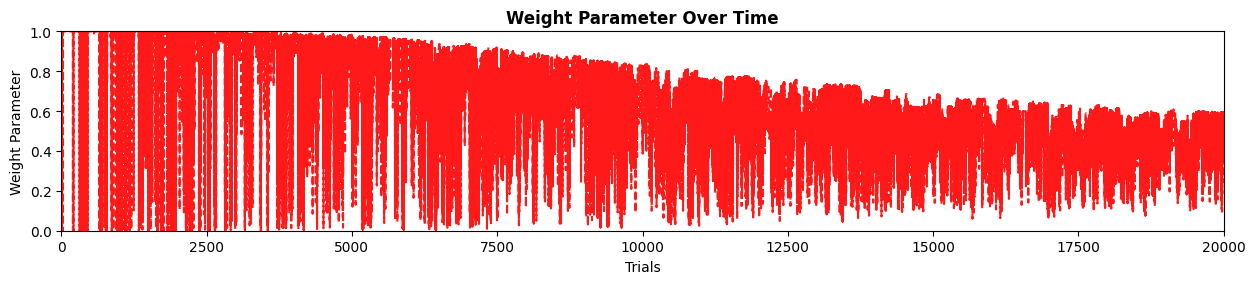

In [153]:
n_trials = 20000
alpha = 0.5
beta = 4
lower = 0.5
upper = 0.9


# run the agent
[stay, state_sim, prev_rews, rewards, ws, avg_rew] = mb_mf_meta_agent(n_trials, alpha, beta, lower, upper)

## Make plot:
# Define plot sizes
ax = plt.subplots(figsize=(15, 4), facecolor='w')
ax = plt.subplot2grid((3, 1), (0, 0), colspan=1, rowspan=2)

# Plotting Weight parameter changes
ax.plot(ws, color='#FF0000', alpha=0.9, linestyle='--')
ax.set_ylabel('Weight Parameter')
ax.set_xlabel('Trials')
ax.set_title(r'Weight Parameter Over Time', fontweight='bold')
ax.set_ylim(0, 1)
ax.set_xlim(0, n_trials)
plt.show()

In [154]:
# Average Weight parameter
np.nanmean(ws)

0.650590674885024

/var/folders/2h/rbgs1pj11x78nty2hw5d0jyr0000gn/T/ipykernel_96810/3324567135.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1, rowspan=2)


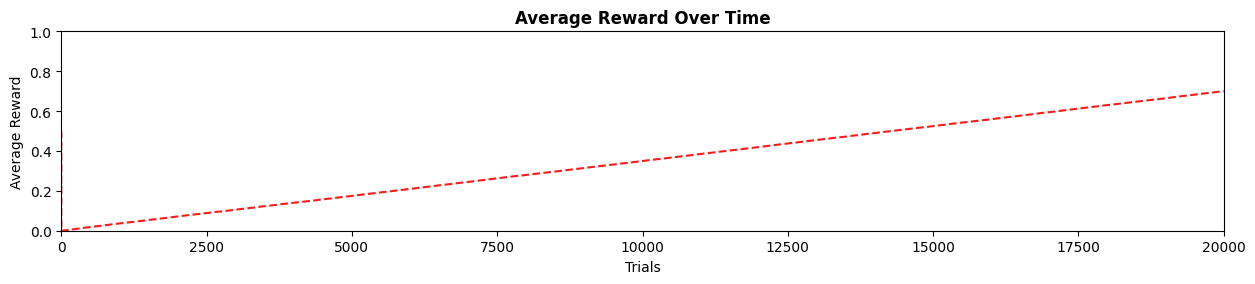

In [102]:
# Plot of average reward
ax = plt.subplots(figsize=(15, 4), facecolor='w')
ax = plt.subplot2grid((3, 1), (0, 0), colspan=1, rowspan=2)
ax.plot(avg_rew, color='#FF0000', alpha=0.9, linestyle='--')
ax.set_ylabel('Average Reward')
ax.set_xlabel('Trials')
ax.set_title(r'Average Reward Over Time', fontweight='bold')
ax.set_ylim(0, 1)
ax.set_xlim(0, n_trials)
plt.show()

/var/folders/2h/rbgs1pj11x78nty2hw5d0jyr0000gn/T/ipykernel_96810/757736345.py:55: RuntimeWarning: invalid value encountered in divide
  w = np.square(sig((controllability)/(avg_reward)))
/var/folders/2h/rbgs1pj11x78nty2hw5d0jyr0000gn/T/ipykernel_96810/757736345.py:55: RuntimeWarning: divide by zero encountered in divide
  w = np.square(sig((controllability)/(avg_reward)))
/var/folders/2h/rbgs1pj11x78nty2hw5d0jyr0000gn/T/ipykernel_96810/2759781898.py:10: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


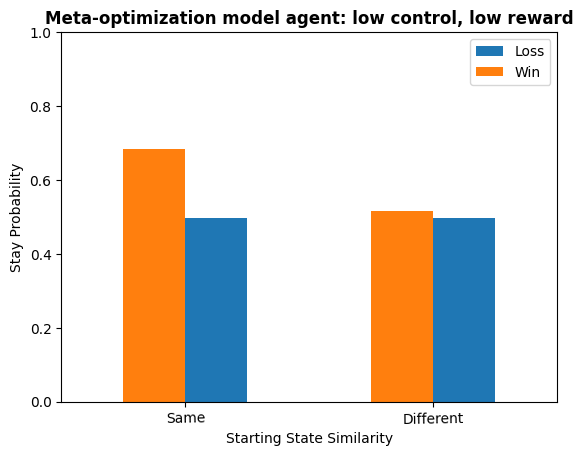

In [145]:
# Run an agent and plot the data
n_trials = 20000
alpha = 0.5
beta = 4
w = 0.5
lower = 0.3
upper = 0.3
plt.rcParams.update({'font.size': 10})


# to print correct title on plot
if w == 0:
    behave = 'model-free'
elif w == 1:
    behave = 'model-based'
else:
    behave = 'Meta-optimization model'

    
#[stay, state_sim, prev_rews, rewards] = mb_mf_agent(n_trials, alpha, beta, w, lower, upper)

[stay, state_sim, prev_rews, rewards, ws, avg_rew] = mb_mf_meta_agent(n_trials, alpha, beta, lower, upper)

# calculate probabilities
df = pd.DataFrame({"Rocket_State_Sim":state_sim,"Previous_Rewards":prev_rews,"Stay":stay})
plot_data = df.groupby(["Rocket_State_Sim","Previous_Rewards"]).mean().unstack()
a = plot_data.reset_index()

# plot the graph
fig, ax = plt.subplots()
a.plot(x = "Rocket_State_Sim", kind="bar", ylim = [0,1],
       stacked=False,ax=ax)

# figure legends
ax.legend(["Loss","Win"])
ax.set_ylabel("Stay Probability")
plt.xticks(rotation=1)
ax.set_xticklabels(['Different','Same'])
ax.set_xlabel("Starting State Similarity")
ax.invert_xaxis()

# title corresponding to w value
ax.set_title(f'{behave} agent: low control, low reward', fontweight='bold')

# text bubble for w according to value
# ax.text(-0.6,0.9, f'w = {w}', color = 'black', size=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle = 'round'))
plt.show()

In [117]:
# Performance accuracies of models

n_trials = 20000
alpha = 0.5
beta = 4
lower = 0.3
upper = 0.3

# simulate a model-based agent and check performance
w = 1

[stay, state_sim, prev_rews, mb_rewards] = mb_mf_agent(n_trials, alpha, beta, w, lower, upper)

# calculate performance 
mb_score = sum(mb_rewards)*100 / n_trials
print(f'Model-based performance: {round(mb_score,2)}% of the trials\n')

# Simulate a model-free agent and check performance
# we will use the same values as above, except that we set w to 0
w = 0

[stay, state_sim, prev_rews, mf_rewards] = mb_mf_agent(n_trials, alpha, beta, w, lower, upper)

# calculate performance 
mf_score = sum(mf_rewards)*100 / n_trials
print(f'Model-free performance: {round(mf_score,2)}% of the trials\n')


#meta decision agent
[stay, state_sim, prev_rews, rewards, ws, avg_rew] = mb_mf_meta_agent(n_trials, alpha, beta, lower, upper)
# calculate performance 
m_score = sum(rewards)*100 / n_trials
print(f'Meta model performance: {round(m_score,2)}% of the trials\n')



Model-based performance: 31.52% of the trials

Model-free performance: 30.48% of the trials



/var/folders/2h/rbgs1pj11x78nty2hw5d0jyr0000gn/T/ipykernel_96810/757736345.py:55: RuntimeWarning: invalid value encountered in divide
  w = np.square(sig((controllability)/(avg_reward)))
/var/folders/2h/rbgs1pj11x78nty2hw5d0jyr0000gn/T/ipykernel_96810/757736345.py:55: RuntimeWarning: divide by zero encountered in divide
  w = np.square(sig((controllability)/(avg_reward)))
/var/folders/2h/rbgs1pj11x78nty2hw5d0jyr0000gn/T/ipykernel_96810/2759781898.py:10: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Meta model performance: 29.62% of the trials

